# Variant functional consequences

This notebook provides a summary of the functional consequences of lead variants


## Data Loading

The data required for the analysis is loaded from the `computed maf` dataset.


In [1]:
from __future__ import annotations

import pandas as pd
import plotnine as pn
from gentropy.common.session import Session
from pyspark.sql import Column, Window
from pyspark.sql import functions as f

from manuscript_methods import OpenTargetsTheme, calculate_protein_altering_proportion
from manuscript_methods.datasets import LeadVariantEffect


Loading BokehJS ...

In [2]:
session = Session(extended_spark_conf={"spark.driver.memory": "40G"})
lead_maf_dataset_path = "../../data/filtered_lead_variant_effect_replicated"


25/06/30 08:11:18 WARN Utils: Your hostname, mindos resolves to a loopback address: 127.0.1.1; using 192.168.0.100 instead (on interface eno1)
25/06/30 08:11:18 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/06/30 08:11:18 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/06/30 08:11:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
session.spark


In [4]:
# Limit to only cis-pQTL, GWAS and eQTL studies
dataset_maf = LeadVariantEffect.from_parquet(session, lead_maf_dataset_path).limit()


In [5]:
maf_vep_dataset = dataset_maf.df.select(
    "variantId",
    "leadVariantConsequence.*",
    "studyStatistics.studyType",
    "majorLdPopulationMaf.value",
    "rescaledStatistics.*",
).select("variantId", "type", "transcriptConsequence.consequenceScore", "studyType", "value", "estimatedBeta")
maf_vep_dataset.show()


+-----------------+--------------+----------------+---------+-------------------+--------------------+
|        variantId|          type|consequenceScore|studyType|              value|       estimatedBeta|
+-----------------+--------------+----------------+---------+-------------------+--------------------+
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.200816030227229|  1.0683440646238043|
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.200816030227229|  1.4324239499327505|
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.200816030227229|  1.4463578870346558|
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.200816030227229| -0.6227144774081669|
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.200816030227229|  1.1257443474952906|
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.200816030227229|  0.5998610512969437|
|10_100945301_A_AT|in-gene-effect|             0.0|     eqtl|  0.20081603

## Proportion of altering / non altering vs maf bins


In [93]:
PRECISION = 20  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION))  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("value") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("value") * PRECISION) / PRECISION
bucket_dataset = (
    maf_vep_dataset.withColumns(
        {
            "minRange": f.round(
                f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit), PRECISION_FACTOR
            ),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 1))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .withColumn(
        "meanAbsEstimatedBeta", f.mean(f.abs(f.col("estimatedBeta"))).over(Window.partitionBy("bucket", "studyType"))
    )
    .withColumn(
        "stddevAbsEstimatedBeta",
        f.stddev(f.abs(f.col("estimatedBeta"))).over(Window.partitionBy("bucket", "studyType")),
    )
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        f.col("value").alias("MAF"),
        "minRange",
        "maxRange",
        "midPoint",
        "stddevAbsEstimatedBeta",
        "meanAbsEstimatedBeta",
    )
)


In [94]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


[0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475]


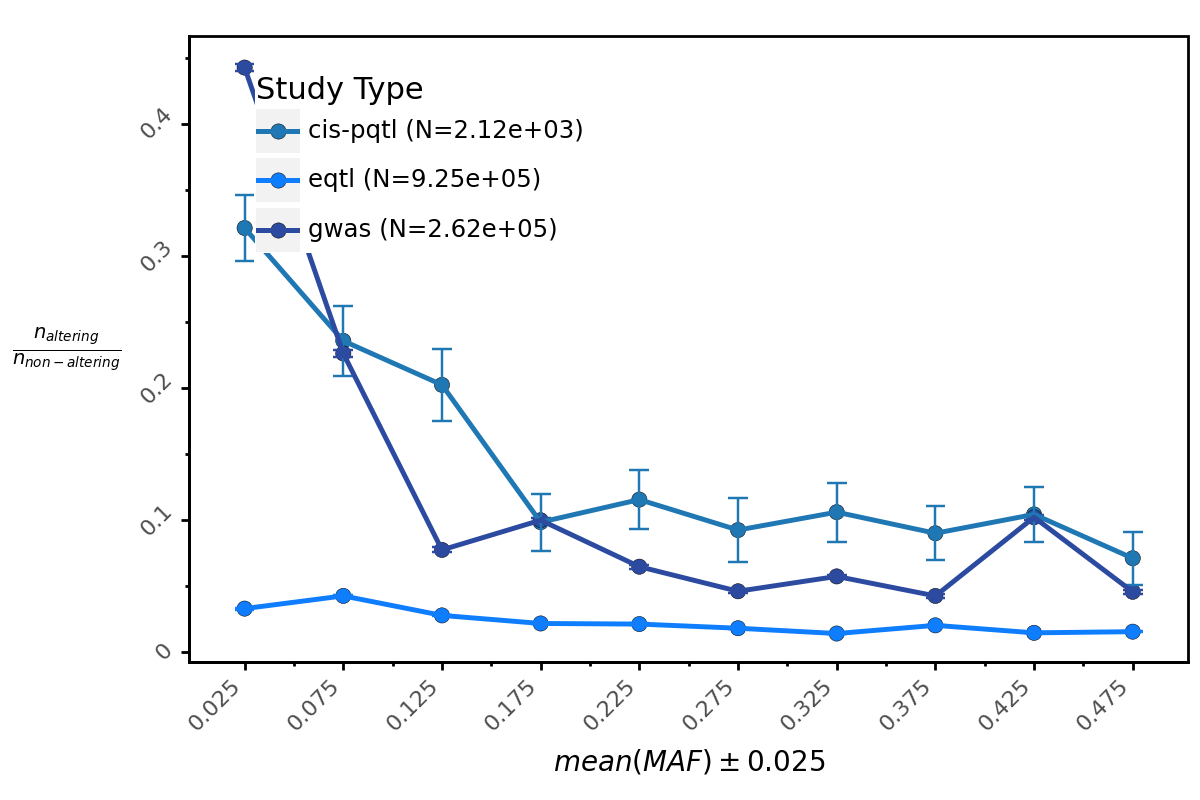

<Figure Size: (600 x 400)>

In [95]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10
breaks = [x for x in data["midPoint"].unique()]
print(breaks)
plot = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="alteringNonAlteringProportionInBucket", fill="studyType"),
    )
    # + pn.geom_col(position="dodge")
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
            x="midPoint",
            color="studyType",
        ),
        width=0.01,
        # position=pn.position_dodge(width=0.9),
    )
    + pn.labs(
        # title="Proportion of lead variant effects in replicated credible sets",
        x=r"$mean(MAF)\pm{0.025}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}$ ",
    )
    + OpenTargetsTheme.theme
    # Remove the legend
    # + pn.theme(legend_position="none")
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="alteringNonAlteringProportionInBucket", group="studyType", color="studyType"),
        size=1,
    )
    + pn.theme(figure_size=(6, 4))
    + pn.scale_fill_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + pn.theme(legend_position=(0.35, 0.80), legend_direction="vertical")
)
plot


In [96]:
data.columns


Index(['variantId', 'type', 'nAlteringInBucket', 'nNonAlteringInBucket',
       'alteringNonAlteringProportionInBucket', 'stdErr', 'totalInBucket',
       'consequenceScore', 'studyType', 'bucket', 'MAF', 'minRange',
       'maxRange', 'midPoint', 'stddevAbsEstimatedBeta',
       'meanAbsEstimatedBeta', 'totals'],
      dtype='object')

## Mean absolute estimated effect size vs MAF bins

[0.025, 0.075, 0.125, 0.175, 0.225, 0.275, 0.325, 0.375, 0.425, 0.475]


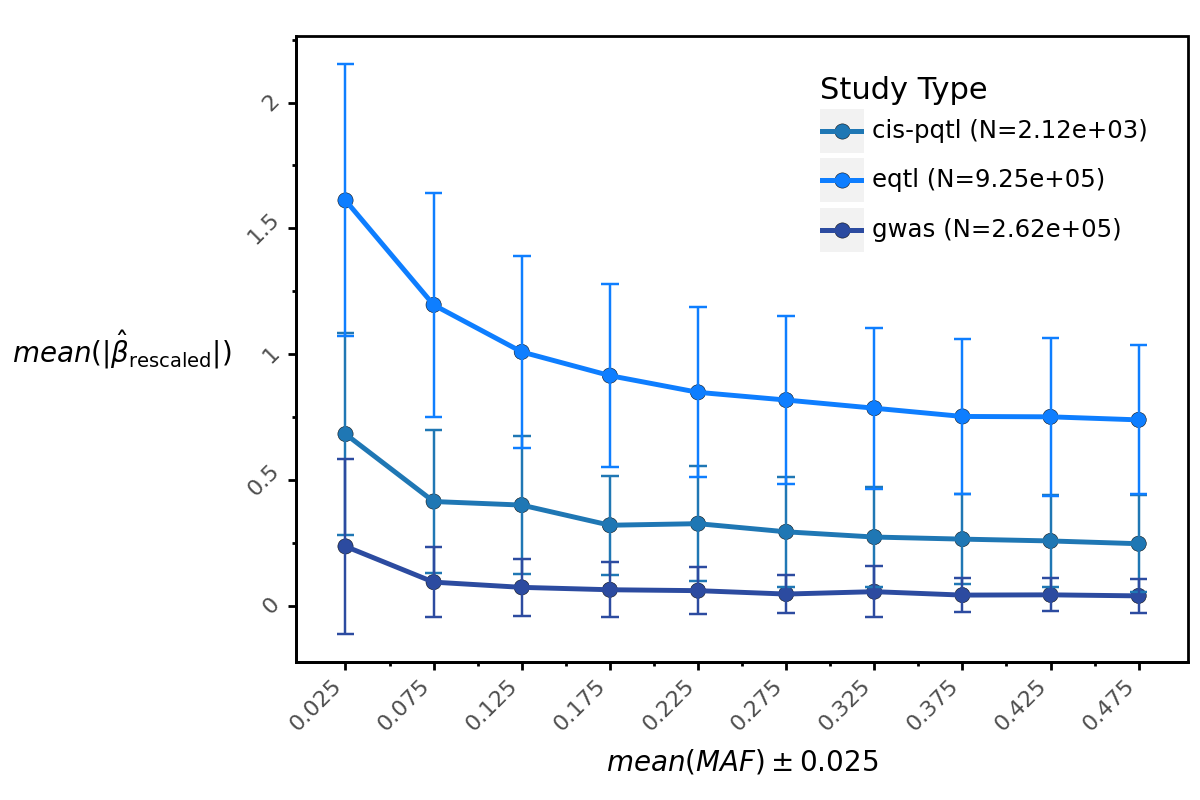

<Figure Size: (600 x 400)>

In [97]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10
breaks = [x for x in data["midPoint"].unique()]
print(breaks)
plot2 = (
    pn.ggplot(
        data,
        pn.aes(x="midPoint", y="meanAbsEstimatedBeta", fill="studyType"),
    )
    # + pn.geom_col(position="dodge")
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="meanAbsEstimatedBeta - stddevAbsEstimatedBeta",
            ymax="meanAbsEstimatedBeta + stddevAbsEstimatedBeta",
            x="midPoint",
            color="studyType",
        ),
        width=0.01,
        # position=pn.position_dodge(width=0.9),
    )
    + pn.labs(
        # title="Proportion of lead variant effects in replicated credible sets",
        x=r"$mean(MAF)\pm{0.025}$",
        y=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)$",
    )
    + OpenTargetsTheme.theme
    # Remove the legend
    # + pn.theme(legend_position="none")
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="meanAbsEstimatedBeta", group="studyType", color="studyType"),
        size=1,
    )
    + pn.theme(figure_size=(6, 4))
    + pn.scale_fill_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + pn.theme(legend_position=(0.82, 0.8), legend_direction="vertical")
)
plot2


## Proportion of altering / non altering vs abs(estimatedBeta) bins


In [98]:
PRECISION = 2  # Needs to be the power of 10
PRECISION_FACTOR = len(str(PRECISION)) - 1  # Number of digits in the precision factor
upper_limit = f.ceil(f.col("absEstimatedBeta") * PRECISION) / PRECISION
lower_limit = f.floor(f.col("absEstimatedBeta") * PRECISION) / PRECISION

bucket_dataset = (
    maf_vep_dataset.withColumn("absEstimatedBeta", f.abs("estimatedBeta"))
    .withColumns(
        {
            "minRange": f.when(upper_limit == lower_limit, lower_limit - 1 / PRECISION).otherwise(lower_limit),
            "maxRange": upper_limit,
        }
    )
    .withColumn("midPoint", f.round((f.col("minRange") + f.col("maxRange")) / 2, PRECISION_FACTOR + 2))
    .withColumn("bucket", f.concat(f.col("minRange"), f.lit("-"), f.col("maxRange")))
    .withColumn("vepProportion", calculate_protein_altering_proportion(f.col("consequenceScore")))
    .orderBy("bucket")
    .select(
        "variantId",
        "type",
        "vepProportion.*",
        "consequenceScore",
        "studyType",
        "bucket",
        "absEstimatedBeta",
        "minRange",
        "maxRange",
        "midPoint",
    )
)


In [99]:
maf_vep_dataset.groupBy("studyType").agg(
    f.mean(f.abs("EstimatedBeta")),
    f.max(f.abs("estimatedBeta")),
    f.min(f.abs("estimatedBeta")),
).show()


+---------+-----------------------+-----------------------+-----------------------+
|studyType|avg(abs(EstimatedBeta))|max(abs(estimatedBeta))|min(abs(estimatedBeta))|
+---------+-----------------------+-----------------------+-----------------------+
| cis-pqtl|    0.37968404636822156|      2.091797136698118|    0.03649146430619789|
|     gwas|    0.08910094457029878|     2.9990395847218516|   0.004562289308096243|
|     eqtl|     0.9126269115100052|      2.999975493530603|     0.1811207497017788|
+---------+-----------------------+-----------------------+-----------------------+



In [100]:
data = bucket_dataset.drop_duplicates(["bucket", "studyType"]).toPandas()


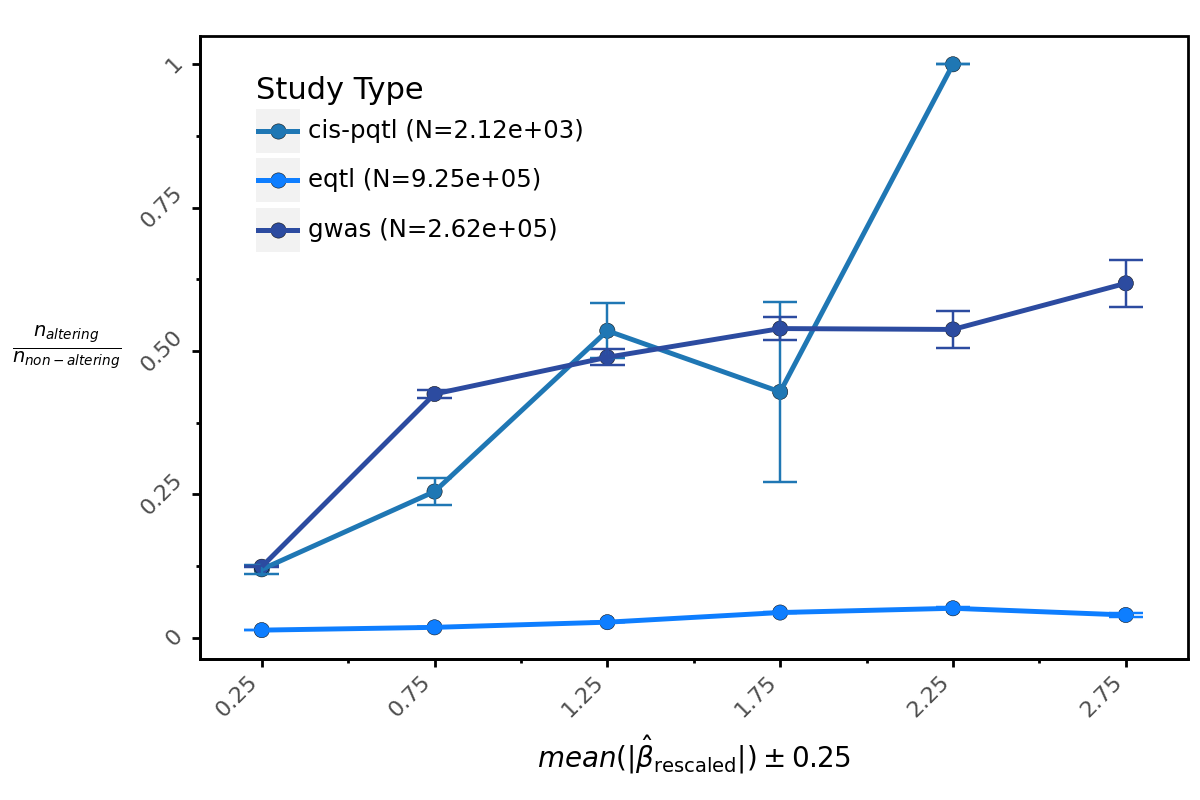

<Figure Size: (600 x 400)>

In [101]:
study_type_totals = data.groupby("studyType")["totalInBucket"].sum()
totals_map = {cat: f"{cat} (N={study_type_totals[cat]:.2e})" for cat in study_type_totals.index}
data["totals"] = data["studyType"].map(totals_map)
labels = data.drop_duplicates(subset=["studyType", "totals"])
REM = 10

plot3 = (
    pn.ggplot(
        data,
        pn.aes(
            x="midPoint",
            y="alteringNonAlteringProportionInBucket",
            fill="studyType",
        ),
    )
    + pn.geom_point(pn.aes(fill="studyType"), stroke=0.1, size=3)
    + pn.geom_errorbar(
        pn.aes(
            ymin="alteringNonAlteringProportionInBucket - stdErr",
            ymax="alteringNonAlteringProportionInBucket + stdErr",
            x="midPoint",
            color="studyType",
        ),
        width=0.1,
    )
    + pn.labs(
        # title="Proportion of Protein-Altering Variants by Rescaled Effect Size Bucket",
        x=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)\pm{0.25}$",
        y=r"$\frac{n_{altering}}{n_{non-altering}}$ ",
    )
    + pn.scale_x_continuous(
        breaks=[x for x in data["midPoint"].unique()],
        labels=[x for x in data["midPoint"].unique()],
    )
    + OpenTargetsTheme.theme
    # + pn.facet_wrap(nrow=3, facets="studyType", scales="free_y")
    + pn.geom_line(
        pn.aes(x="midPoint", y="alteringNonAlteringProportionInBucket", group="studyType", color="studyType"),
        size=1,
    )
    + pn.theme(figure_size=(6, 6))
    + pn.scale_fill_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.scale_color_manual(
        values=["#1f77b4", "#0e7eff", "#2c4ba0"],
        name="Study Type",
        labels=totals_map,
    )
    + pn.theme(legend_position=(0.35, 0.8), legend_direction="vertical")
    + pn.theme(figure_size=(6, 4))
)
plot3


## Save plots into 1 figure

In [ ]:
type(plot3)


plotnine.ggplot.ggplot

In [106]:
import patchworklib as pw

plots = {"vep_proportion_vs_maf": plot, "effect_size_vs_maf": plot2, "vep_proportion_vs_abs_beta": plot3}
g1 = pw.load_ggplot(plot)
g2 = pw.load_ggplot(plot2)
g3 = pw.load_ggplot(plot3)
fig = g1 | g2 / g3
fig


TypeError: cannot unpack non-iterable Figure object

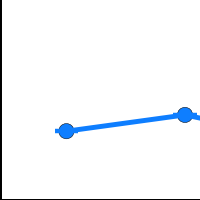

In [105]:
fig.savefig("plots/04_variant_functional_consequence.jpg", dpi=300, bbox_inches="tight")


## Altering vs non-altering variant counts

Only for GWAS - mean(abs(beta))+-SD vs categories of the variant (only for varaints with maf>=0.01)

In [ ]:
replicated_gwas_credible_sets = (
    dataset_maf.df.select(
        "variantId",
        "leadVariantConsequence.*",
        "studyStatistics.studyType",
        "majorLdPopulationMaf.value",
        "rescaledStatistics.*",
    )
    .select(
        "variantId",
        "type",
        "transcriptConsequence.consequenceScore",
        "studyType",
        f.col("value").alias("MAF"),
        "estimatedSE",
        f.abs("estimatedBeta").alias("absEstimatedBeta"),
    )
    .filter(f.col("MAF") >= 0.01)
    .filter(f.col("studyType").isin(["gwas"]))
    .withColumn("alteringStatus", f.when(f.col("consequenceScore") >= 0.66, "altering").otherwise("non-altering"))
    .groupBy("studyType", "alteringStatus")
    .agg(
        f.mean("MAF").alias("meanMAF"),
        (f.stddev("MAF") / f.sqrt(f.count("MAF"))).alias("stdErrMAF"),
        f.mean("absEstimatedBeta").alias("MeanAbsEstimatedBeta"),
        (f.stddev("absEstimatedBeta") / f.sqrt(f.count("absEstimatedBeta"))).alias("StdErrAbsEstimatedBeta"),
        f.count("variantId").alias("nCredibleSets"),
    )
    .orderBy("studyType", f.desc("alteringStatus"))
)

replicated_gwas_credible_sets.show()
data = replicated_gwas_credible_sets.toPandas()

data["alteringStatus"] = pd.Categorical(data["alteringStatus"], categories=["non-altering", "altering"], ordered=True)
data["%"] = round(data["nCredibleSets"] / sum(data["nCredibleSets"]) * 100, 2)
data["labels"] = data["nCredibleSets"].apply(lambda x: f"{x:,}") + " (" + data["%"].astype(str) + "%)"
data


+---------+--------------+-------------------+--------------------+--------------------+----------------------+-------------+
|studyType|alteringStatus|            meanMAF|           stdErrMAF|MeanAbsEstimatedBeta|StdErrAbsEstimatedBeta|nCredibleSets|
+---------+--------------+-------------------+--------------------+--------------------+----------------------+-------------+
|     gwas|  non-altering| 0.2611988336244588|3.033166271302712...|0.060944292661806225|  2.061868291137033E-4|       220935|
|     gwas|      altering|0.15941665291087334|9.426026492784371E-4|  0.1257850364330383|  0.001166076990288597|        25338|
+---------+--------------+-------------------+--------------------+--------------------+----------------------+-------------+



,studyType,alteringStatus,meanMAF,stdErrMAF,MeanAbsEstimatedBeta,StdErrAbsEstimatedBeta,nCredibleSets,%,labels
0,gwas,non-altering,0.261199,0.000303,0.060944,0.000206,220935,89.71,"220,935 (89.71%)"
1,gwas,altering,0.159417,0.000943,0.125785,0.001166,25338,10.29,"25,338 (10.29%)"


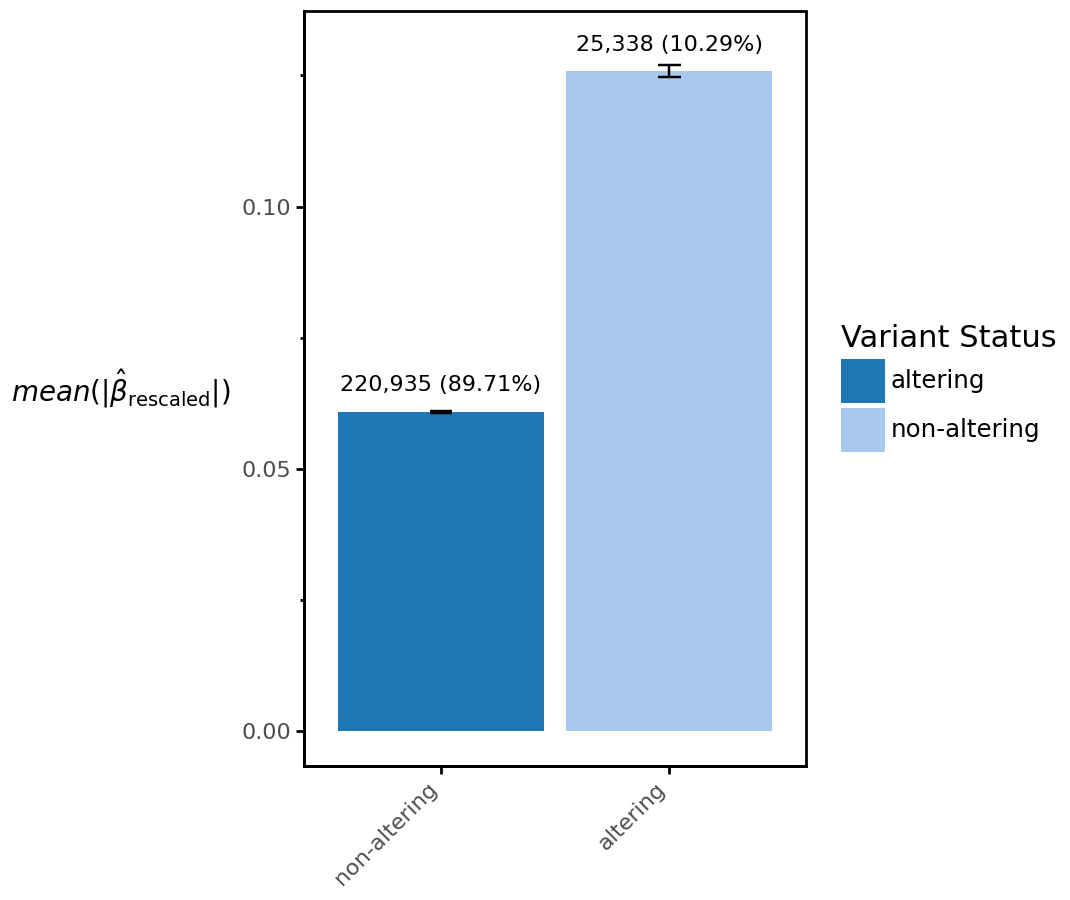

In [307]:
plot = (
    pn.ggplot(data=data, mapping=pn.aes(x="alteringStatus", y="MeanAbsEstimatedBeta", fill="alteringStatus"))
    + OpenTargetsTheme.theme
    + pn.geom_col()
    + pn.scale_fill_manual(
        values=["#1f77b4", "#a8c8ee", "#2c4ba0"],
        name="Variant Status",
        labels=["altering", "non-altering"],
    )
    + pn.geom_errorbar(
        pn.aes(
            ymin="MeanAbsEstimatedBeta - StdErrAbsEstimatedBeta", ymax="MeanAbsEstimatedBeta + StdErrAbsEstimatedBeta"
        ),
        width=0.1,
    )
    + pn.labs(x="", y=r"$mean(|\hat{\beta}_{\mathrm{rescaled}}|)$")
    + pn.geom_text(
        pn.aes(y="MeanAbsEstimatedBeta", label="labels"),
        # Position at the top of the bar
        position=pn.position_nudge(y=0.005),
        # position=pn.position_dodge(width=0.5),
        size=8,
        color="black",
    )
)
plot
